# CSC 2621 Final Project: Running (Away)
### Members: Alex Ewart, Mikhail Filippov, Benjamin Liebl

In this Final Project, we will perform statistical analyses and use different models for a [Running](https://www.kaggle.com/datasets/mexwell/long-distance-running-dataset?resource=download&select=run_ww_2019_w.csv) dataset.

Our research questions include:
1. Is there a significant difference in the distance athletes ran in 2019 vs 2020 due to the COVID pandemic?
2. Can we accurately predict an athletes weekly running distance based on previous weeks?

Our hypotheses are:
1. During the year 2020, athletes ran **less** distance overall than the same athletes in the year 2019.
2. We can achieve better RMSE when predicting the X week's running distance based on the previous X-1 weeks in 2019 than the RMSE from picking a mean value for each athlete's X-1 weeks to predict X using RandomForestRegressor, LSTM, and XGBoost models.


### About the [dataset](https://www.kaggle.com/datasets/mexwell/long-distance-running-dataset?resource=download&select=run_ww_2019_w.csv)
The "Long-Distance Running Dataset" was obtained from Kaggle and contains the running statistics of 36,412 athletes from around the world. The data was obtained off of a large social network for athletes. The features present in the dataset include:
1. datetime: date of the running activity
2. athlete: a computer-generated ID for the athlete (integer)
3. distance: distance of running (floating-point number, in kilometers)
4. duration: duration of running (floating-point number, in minutes)
5. gender: gender (string 'M' of 'F')
6. age_group: age interval (one of the strings '18 - 34', '35 - 54', or '55 +')
7. country: country of origin of the athlete (string)
8. major: marathon(s) and year(s) the athlete ran (comma-separated list of strings)

This dataset has been conveniently split up into several frequencies of data, included by day, week, month, and quarter. We will be using the weekly data in order to have a finer dataset while keeping it relatively on the smaller end.

Our target variable will be the Xth week's distance to predict, while the features will include the X-1 weeks beforehand, gender, age_group, country, and major.

It is important to note that for most of the modeling, we will be using the **2019 dataset** as to not include abnormalities that could be present in 2020 due to COVID.

In [44]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import kruskal
from tqdm import tqdm
import dill
import os

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# import saved data to avoid rerunning
if os.path.exists('final_project.db'):
    dill.load_session('final_project.db')
if os.path.exists('random_forest.db'):
    dill.load_session('random_forest.db')

### Data Preprocessing

In [60]:
# load data
df_2019 = pd.read_csv('../run_ww_2019_w.csv')
df_2020 = pd.read_csv('../run_ww_2020_w.csv')

# convert 2019 objects to correct types
df_2019['datetime'] = pd.to_datetime(df_2019['datetime'], format='%Y-%m-%d')
df_2019['gender'] = df_2019['gender'].astype('category')
df_2019['age_group'] = df_2019['age_group'].astype('category')
df_2019['country'] = df_2019['country'].astype('category')
df_2019['major'] = df_2019['major'].astype('category')
df_2019.drop(columns=['Unnamed: 0'], inplace=True)

# convert 2020 objects to correct types
df_2020['datetime'] = pd.to_datetime(df_2020['datetime'], format='%Y-%m-%d')
df_2020['gender'] = df_2020['gender'].astype('category')
df_2020['age_group'] = df_2020['age_group'].astype('category')
df_2020['country'] = df_2020['country'].astype('category')
df_2020['major'] = df_2020['major'].astype('category')
df_2020.drop(columns=['Unnamed: 0'], inplace=True)

display(df_2019.head())
display(df_2020.head())
display(df_2019.info())
display(df_2020.info())

,datetime,athlete,distance,duration,gender,age_group,country,major
0,2019-01-01,0,0.00,0.00,F,18 - 34,United States,CHICAGO 2019
1,2019-01-01,1,5.27,30.20,M,35 - 54,Germany,BERLIN 2016
2,2019-01-01,2,9.30,98.00,M,35 - 54,United Kingdom,"LONDON 2018,LONDON 2019"
3,2019-01-01,3,103.13,453.40,M,18 - 34,United Kingdom,LONDON 2017
4,2019-01-01,4,34.67,185.65,M,35 - 54,United States,BOSTON 2017


,datetime,athlete,distance,duration,gender,age_group,country,major
0,2020-01-01,0,0.00,0.000000,F,18 - 34,United States,CHICAGO 2019
1,2020-01-01,1,70.33,394.200000,M,35 - 54,Germany,BERLIN 2016
2,2020-01-01,2,14.65,79.066667,M,35 - 54,United Kingdom,"LONDON 2018,LONDON 2019"
3,2020-01-01,3,41.41,195.666667,M,18 - 34,United Kingdom,LONDON 2017
4,2020-01-01,4,41.34,209.100000,M,35 - 54,United States,BOSTON 2017


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1893424 entries, 0 to 1893423
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   datetime   datetime64[ns]
 1   athlete    int64         
 2   distance   float64       
 3   duration   float64       
 4   gender     category      
 5   age_group  category      
 6   country    category      
 7   major      category      
dtypes: category(4), datetime64[ns](1), float64(2), int64(1)
memory usage: 68.7 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1893424 entries, 0 to 1893423
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   datetime   datetime64[ns]
 1   athlete    int64         
 2   distance   float64       
 3   duration   float64       
 4   gender     category      
 5   age_group  category      
 6   country    category      
 7   major      category      
dtypes: category(4), datetime64[ns](1), float64(2), int64(1)
memory usage: 68.7 MB


None

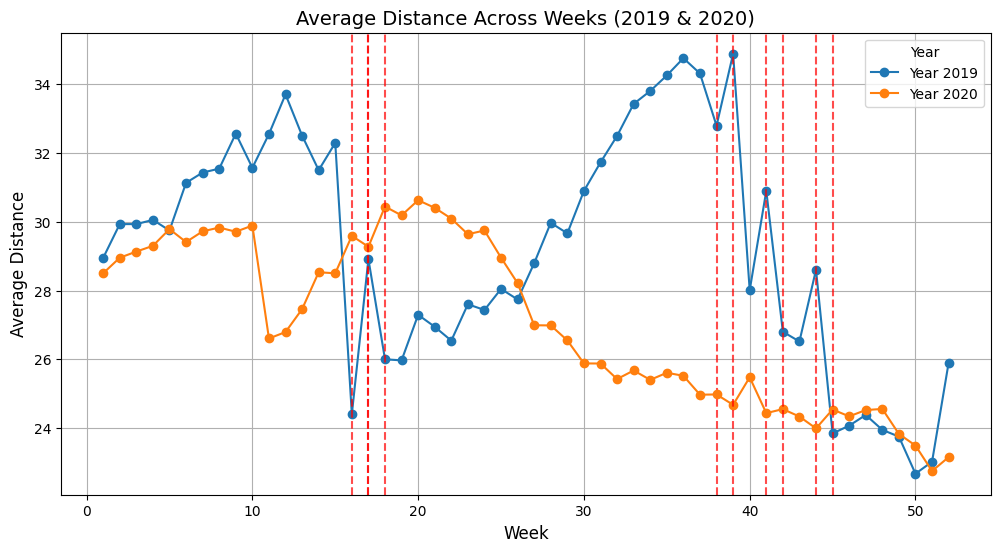

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Combine the 2019 and 2020 dataframes
df_combined = pd.concat([df_2019, df_2020], ignore_index=True)

# Ensure the 'datetime' column is in datetime format
df_combined['datetime'] = pd.to_datetime(df_combined['datetime'])

# Extract the year and week number from the datetime column
df_combined['year'] = df_combined['datetime'].dt.year
df_combined['week'] = df_combined['datetime'].dt.isocalendar().week

# Group by both year and week, and calculate the average distance
average_distance_per_week = df_combined.groupby(['year', 'week'])['distance'].mean().reset_index()

marathon_map = {
    'CHICAGO': '10-12',
    'BERLIN': '09-21',
    'LONDON': '04-27',
    'BOSTON': '04-21',
    'NEW YORK': '11-02'
}

# Function to convert 'MM-DD' to (year, week) format
def get_week_from_date(year, date_str):
    date = datetime.strptime(f"{year}-{date_str}", '%Y-%m-%d')
    # Ensure the week is calculated for the correct year
    week = date.isocalendar()[1]
    return week

# Plot the average distance across weeks for each year
plt.figure(figsize=(12, 6))
for year in average_distance_per_week['year'].unique():
    data = average_distance_per_week[average_distance_per_week['year'] == year]
    plt.plot(data['week'], data['distance'], marker='o', label=f'Year {year}')

    # Add vertical lines for each marathon
    for marathon, date_str in marathon_map.items():
        week = get_week_from_date(year, date_str)
        plt.axvline(x=week, color='red', linestyle='--', alpha=0.7)

plt.title('Average Distance Across Weeks (2019 & 2020)', fontsize=14)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Average Distance', fontsize=12)
plt.legend(title='Year')
plt.grid(True)
plt.show()


In [8]:
# adding marathon features to see if a week is within a 1 month of a major marathon for the athlete
marathon_map = {
    'CHICAGO': '10-12',
    'BERLIN': '09-21',
    'LONDON': '04-27',
    'BOSTON': '04-21',
    'NEW YORK': '11-02'
}

df_expanded = df_2019.copy()
df_expanded['major_split'] = df_expanded['major'].str.split(',')
df_expanded = df_expanded.explode('major_split')

df_expanded[['event', 'year']] = df_expanded['major_split'].str.extract(r'(\D+)\s+(\d{4})')
df_expanded['event'] = df_expanded['event'].str.strip()
df_expanded['year'] = df_expanded['year'].astype(int)
df_expanded['major_date'] = pd.to_datetime(
    df_expanded['year'].astype(str) + '-' + df_expanded['event'].map(marathon_map),
    errors='coerce'
)

In [9]:
one_month = pd.Timedelta(days=30)

# Check conditions
df_expanded['within-month-before'] = (
    (df_expanded['datetime'] > df_expanded['major_date'] - one_month) &
    (df_expanded['datetime'] <= df_expanded['major_date'])
)

df_expanded['within-month-after'] = (
    (df_expanded['datetime'] > df_expanded['major_date']) &
    (df_expanded['datetime'] <= df_expanded['major_date'] + one_month)
)

# Group back to original rows and aggregate using any()
df_result = df_expanded.groupby(df_expanded.index)[['within-month-before', 'within-month-after']].any()
df_result

,within-month-before,within-month-after
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
1893419,False,False
1893420,False,False
1893421,False,False
1893422,False,False


In [10]:
df_2019 = df_2019.join(df_result)

In [11]:
# pivot the datetime data to columns in order to effectively use it within the models as features
df_2019_new = df_2019.pivot_table(
    index='athlete',
    columns='datetime',
    values=['distance', 'duration', 'within-month-before', 'within-month-after'],
    aggfunc='sum',
    fill_value=0
)
df_2019_new.columns = [
    f'{val}_week_{date.isocalendar()[1]}' for val, date in df_2019_new.columns
]


df_2019_new = df_2019_new.reset_index()
mask = ~df_2019['athlete'].duplicated()
df_2019_new['age_group'] = df_2019[mask]['age_group']
df_2019_new['country'] = df_2019[mask]['country']
df_2019_new['gender'] = df_2019[mask]['gender']
df_2019_new['major'] = df_2019[mask]['major']
age_map = {}
# compute mean age for each age group to convert to numeric
for age_group in df_2019_new['age_group'].unique():
    ages_split = age_group.split()
    mean_age = 0
    if ages_split[1] == '-':
        mean_age = (int(ages_split[0]) + int(ages_split[2])) / 2
    else:
        mean_age = (55 + 75) / 2
    age_map[age_group] = mean_age
df_2019_new['age_group'] = pd.Series(df_2019_new['age_group'].map(age_map), dtype=float)
df_2019_new = pd.get_dummies(df_2019_new, columns=['country'])
df_2019_new

,athlete,distance_week_1,distance_week_2,distance_week_3,distance_week_4,distance_week_5,distance_week_6,distance_week_7,distance_week_8,distance_week_9,...,country_Uganda,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Venezuela,country_Vietnam,country_Zimbabwe
0,0,0.00,0.000,0.00,0.000,0.000,0.00,0.000,0.00,0.000,...,False,False,False,False,True,False,False,False,False,False
1,1,5.27,59.860,55.99,58.500,58.180,51.59,63.710,62.04,52.480,...,False,False,False,False,False,False,False,False,False,False
2,2,9.30,30.820,10.01,54.340,37.099,58.28,61.690,61.16,71.319,...,False,False,False,True,False,False,False,False,False,False
3,3,103.13,93.100,87.40,97.840,54.870,9.76,87.260,4.88,41.060,...,False,False,False,True,False,False,False,False,False,False
4,4,34.67,0.000,30.51,38.680,0.000,38.30,0.000,8.66,10.160,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36407,37594,168.05,113.140,163.52,161.509,163.320,123.18,66.189,88.89,149.859,...,False,False,False,True,False,False,False,False,False,False
36408,37595,79.81,114.879,113.51,91.680,128.270,136.32,121.530,127.39,134.540,...,False,False,False,False,True,False,False,False,False,False
36409,37596,118.89,111.070,117.22,136.400,134.308,136.25,118.340,90.93,92.400,...,False,False,False,False,True,False,False,False,False,False
36410,37597,28.67,54.410,49.88,41.220,48.930,50.09,75.060,23.43,72.260,...,False,False,False,False,True,False,False,False,False,False


In [ ]:
# data prep for statistical analysis
# convert from timestamp object to datetime in m/d format
df_2019['timestamp'] = pd.to_datetime(df_2019['datetime'])
df_2019['year'] = 2019
df_2020['timestamp'] = pd.to_datetime(df_2020['datetime'])
df_2020['year'] = 2020
# combine
df_2019['month_day'] = df_2019['timestamp'].dt.strftime('%m-%d')
df_2020['month_day'] = df_2020['timestamp'].dt.strftime('%m-%d')
df_2019['day_of_year'] = df_2019['timestamp'].dt.dayofyear
df_2020['day_of_year'] = df_2020['timestamp'].dt.dayofyear
df_years = pd.concat([df_2019, df_2020], ignore_index=True)
df_sampled = df_years.sample(frac=0.05, random_state=1)

In [21]:
def get_features_and_target(week_x, df=df_2019_new, x=3, use_season=True, use_major=True, use_duration=True):
    """"
    This function helps select the features and target variable for model use

    Parameters:
    week_x (int): The week number to use as the target variable
    df (DataFrame): The DataFrame containing the data
    x (int): The number of weeks back to consider for features
    use_season (bool): Whether to include season-based features
    use_major (bool): Whether to include major marathon features
    """
    target = f'distance_week_{week_x}'
    
    # Select time-based features
    features = [
        col for col in df.columns
        if 'week' in col
        and ('within' not in col or use_major)
        and ('duration' not in col or use_duration)
        and (week_x - int(col.split('_')[2])) <= x
        and (week_x - int(col.split('_')[2])) > 0
    ]
    if use_season:
        # Base feature set
        X = df[features + ['gender', 'age_group']].copy()

        X['gender'] = X['gender'].eq('M')

        # One-hot encode age_group
        X = pd.get_dummies(X, columns=['gender'], drop_first=False)
    else:
        X = df[features]

    y = df[target]
    return X, y

In [29]:
# get training and test data
def get_train_test_data(week_x, df=df_2019_new, x=10, use_season=True, use_major=True, use_duration=True):
    """
    This function helps select the training and test data for model use

    Parameters:
    week_x (int): The week number to use as the target variable
    df (DataFrame): The DataFrame containing the data
    x (int): The number of weeks back to consider for features
    use_season (bool): Whether to include season-based features
    use_major (bool): Whether to include major marathon features
    use_duration (bool): Whether to include duration features
    """
    X, y = get_features_and_target(week_x, df, x, use_season, use_major, use_duration)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    return X_train, X_test, y_train, y_test

### Data Analysis

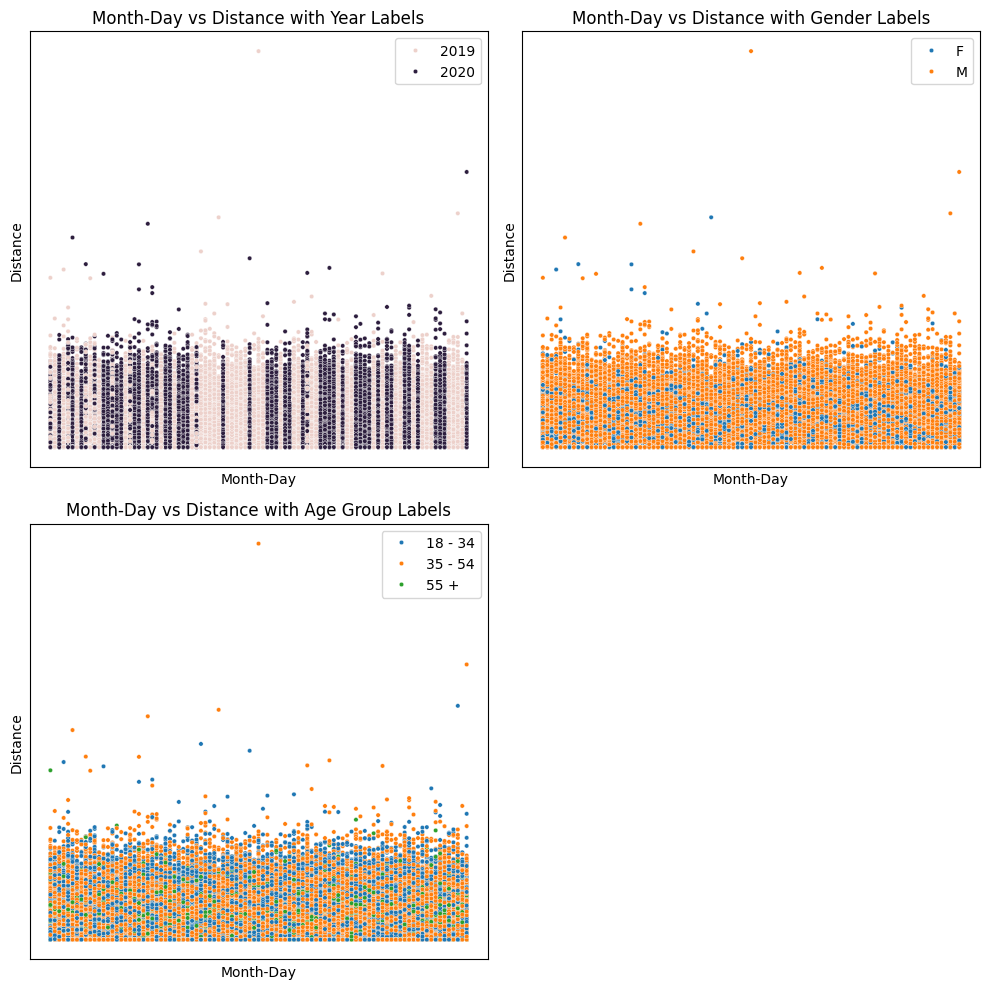

In [51]:
# plot dist vs time comparing year, age, and gender

plt.figure(figsize=(10, 10))
# by year
plt.subplot(2, 2, 1)
sns.scatterplot(data=df_sampled, x='month_day', y='distance', hue='year',s=10)
plt.xlabel('Month-Day')
plt.ylabel('Distance')
plt.title('Month-Day vs Distance with Year Labels')
plt.legend(loc='upper right')
plt.xticks([])
plt.yticks([])

# by gender
plt.subplot(2, 2, 2)
sns.scatterplot(data=df_sampled, x='month_day', y='distance', hue='gender',s=10)
plt.xlabel('Month-Day')
plt.ylabel('Distance')
plt.title('Month-Day vs Distance with Gender Labels')
plt.legend(loc='upper right')
plt.xticks([])
plt.yticks([])

# by age group
plt.subplot(2, 2, 3)
sns.scatterplot(data=df_sampled, x='month_day', y='distance', hue='age_group',s=10)
plt.xlabel('Month-Day')
plt.ylabel('Distance')
plt.title('Month-Day vs Distance with Age Group Labels')
plt.legend(loc='upper right')
plt.xticks([])
plt.yticks([])

plt.tight_layout()

In [52]:
#hyp testing:
# mean distances testing between years
t_statistic, p_value_two = stats.ttest_rel(df_2019['distance'],df_2020['distance'])
if p_value_two <= 0.05:
    print('Reject Null: There is a statistical difference between distances run before and during the COVID pandemic')
    if t_statistic > 0:
        p_value_one = p_value_two/2
        if p_value_one <= 0.05:
            print("Reject Null: Mean distance run decreased during the COVID pandemic")
        else:
            print("Fail to Reject Null: Mean distance did not decrease during the COVID pandemic")
    else:
        p_value_one = 1 - (p_value_two/2)
        if p_value_one <= 0.05:
            print("Reject Null: Mean distance run decreased during the COVID pandemic")
        else:
            print("Fail to Reject Null: Mean distance did not decrease during the COVID pandemic")
else:
    print("Fail to Reject Null: There is no statistical difference between distances run before and during the COVID pandemic")

Reject Null: There is a statistical difference between distances run before and during the COVID pandemic
Reject Null: Mean distance run decreased during the COVID pandemic


In [53]:
# testing distance between countries
# used Kruskal-Wallis as I was comparing more than two paired datasets
country_dist = []
df_country = df_years['country']
country_count = df_country.value_counts()
for countries in country_count.index:
    df_portion =  df_years[df_years['country'] == countries]
    country_dist.append(df_portion['distance'])
stat, p_value = kruskal(*country_dist)
if p_value <= 0.05:
    print("Reject Null: There is a significant difference in distances run by country")
else:
    print("Fail to Reject Null: No significant difference between distances run by country")

Reject Null: There is a significant difference in distances run by country


In [59]:
# mean distance by age group
# same situation as country
age_dist = []
df_age = df_years['age_group']
age_count = df_age.value_counts()
for ages in age_count.index:
    df_portion =  df_years[df_years['age_group'] == ages]
    age_dist.append(df_portion['distance'])
stat, p_value = kruskal(*age_dist)
if p_value <= 0.05:
    print("Reject Null: There is a significant difference in distances run by age group")
else:
    print("Fail to Reject Null: No significant difference between distances run by age group")

Reject Null: There is a significant difference in distances run by age group


In [55]:
# mean distance by gender
male_df = df_years[df_years['gender']=="M"]
female_df = df_years[df_years['gender']=="F"]
stat, p_value = kruskal(male_df['distance'],female_df['distance'])
if p_value <= 0.05:
    print("Reject Null: There is a significant difference in distances run by gender")
else:
    print("Fail to Reject Null: No significant difference between distances run by gender")

Reject Null: There is a significant difference in distances run by gender


### Data Modeling

In [38]:
def train_model_with_kfold(X, y, model_type='rf', k=5):
    """
    Train a model using K-Fold cross-validation.
    
    Parameters:
    X (DataFrame): Feature set.
    y (Series): Target variable.
    model_type (str): Type of model to train ('rf' for Random Forest, 'xgboost' for XGBoost).
    k (int): Number of folds for K-Fold cross-validation.
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    models = []
    rmses = []
    r2_scores = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        if model_type == 'rf':
            model = RandomForestRegressor(
                n_estimators=100,
                max_depth=5,
                min_samples_leaf=5,
                random_state=42
            )
        elif model_type == 'xgboost':
            model = XGBRegressor(
                n_estimators=100,
                max_depth=5,
                learning_rate=0.1,
                objective='reg:squarederror',
                random_state=42
            )
        else:
            raise ValueError("model_type must be 'rf' or 'xgboost'")

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        rmse = mean_squared_error(y_val, y_pred) ** 0.5
        r2 = r2_score(y_val, y_pred)

        rmses.append(rmse)
        r2_scores.append(r2)
        models.append(model)

    avg_rmse = np.mean(rmses)
    avg_r2 = np.mean(r2_scores)

    print(f'Average RMSE across {k} folds ({model_type}): {avg_rmse:.4f}')
    print(f'Average R² Score across {k} folds ({model_type}): {avg_r2:.4f}')

    return models[0]  # return the first trained model

def predict_distance(week_x, model, X, y, use_average=False):
    """
    Score the model using RMSE and R² score.

    Parameters:
    week_x (int): The week number to use as the target variable
    model (object): The trained model.
    """
    if use_average:
        # Predict using the average of each row's 'distance' columns
        distance_cols = [col for col in X.columns if 'distance' in col]
        y_pred = X[distance_cols].mean(axis=1)
        
        # Compute RMSE and R² using per-row averages
        rmse = mean_squared_error(y, y_pred) ** 0.5
        score = r2_score(y, y_pred)
        
        print(f'Per-athlete (row-wise average) RMSE for week {week_x}: {rmse}')
        print(f'Per-athlete (row-wise average) R² score for week {week_x}: {score}')
    else:
        y_pred = model.predict(X)
        rmse = mean_squared_error(y, y_pred) ** 0.5
        score = model.score(X, y)
        
        print(f'Model RMSE for week {week_x}: {rmse}')
        print(f'Model R² score for week {week_x}: {score}')

In [41]:
# generate training and test data for models
# two splits, both predicting week 50 for the past 10 weeks:
# 1. using all features
# 2. using only the distance feature

week_x = 50
last_x = 10
X_train, X_test, y_train, y_test = get_train_test_data(week_x, df=df_2019_new, x=last_x, use_season=True, use_major=True, use_duration=True)
X_train_dist, X_test_dist, y_train_dist, y_test_dist = get_train_test_data(week_x, df=df_2019_new, x=last_x, use_season=False, use_major=False, use_duration=False)

In [42]:
# Random Forest model
model_rf = train_model_with_kfold(X_train, y_train, model_type='rf')
model_rf_dist = train_model_with_kfold(X_train_dist, y_train_dist, model_type='rf')

Average RMSE across 5 folds (rf): 15.0130
Average R² Score across 5 folds (rf): 0.6950
Average RMSE across 5 folds (rf): 15.1080
Average R² Score across 5 folds (rf): 0.6912


In [43]:
# XGBoost model
model_xg = train_model_with_kfold(X_train, y_train, model_type='xgboost')
model_xg_dist = train_model_with_kfold(X_train_dist, y_train_dist, model_type='xgboost')

Average RMSE across 5 folds (xgboost): 14.7763
Average R² Score across 5 folds (xgboost): 0.7046
Average RMSE across 5 folds (xgboost): 14.9821
Average R² Score across 5 folds (xgboost): 0.6962


#### Statistical Testing

In [12]:
import scipy.stats as stats
import numpy as np
#hardcoded values from running previous cells multiple times
data = [
    {"label": "RF - Only Distance", "mean": 17.1008, "std_dev": 0.4125},
    {"label": "RF - Full Features", "mean": 16.9815, "std_dev": 0.4371},
    {"label": "XGB - Only Distance", "mean": 17.5811, "std_dev": 0.4213},
    {"label": "XGB - Full Features", "mean": 17.5103, "std_dev": 0.4056},
    {"label": "RF - Only Distance (Wk 50)", "mean": 14.5689, "std_dev": 0.3527},
    {"label": "RF - Full Features (Wk 50)", "mean": 14.7822, "std_dev": 0.3629},
    {"label": "XGB - Only Distance (Wk 50)", "mean": 15.1069, "std_dev": 0.3748},
    {"label": "XGB - Full Features (Wk 50)", "mean": 15.1773, "std_dev": 0.3392},
]

population_means = [21.0575, 21.0575, 21.0575, 21.0575, 18.1850, 18.1850, 18.1850, 18.1850]

n = 5

for i, entry in enumerate(data):
    sample_mean = entry["mean"]
    std_dev = entry["std_dev"]
    pop_mean = population_means[i]
    
    t_stat = (sample_mean - pop_mean) / (std_dev / np.sqrt(n))
    df = n - 1
    p_value = stats.t.sf(np.abs(t_stat), df) * 2
    
    significant = "yes" if p_value < 0.05 else "no ;-;"
    
    print(f"{entry['label']}: p-value = {p_value} | Statistically Significant? {significant}")


RF - Only Distance: p-value = 2.794518276287498e-05 | Statistically Significant? yes
RF - Full Features: p-value = 3.125847844894981e-05 | Statistically Significant? yes
XGB - Only Distance: p-value = 5.0769299673141744e-05 | Statistically Significant? yes
XGB - Full Features: p-value = 4.032061145015179e-05 | Statistically Significant? yes
RF - Only Distance (Wk 50): p-value = 2.14477921137369e-05 | Statistically Significant? yes
RF - Full Features (Wk 50): p-value = 3.0581298806616966e-05 | Statistically Significant? yes
XGB - Only Distance (Wk 50): p-value = 5.1729914946143845e-05 | Statistically Significant? yes
XGB - Full Features (Wk 50): p-value = 3.817397129470068e-05 | Statistically Significant? yes


### LSTM Model
Please note that this model is different than the one in the results, the actual model was larger and run on ROSIE

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tqdm import tqdm

In [ ]:
df = df_2019
df['week'] = df['datetime'].apply(lambda date: date.isocalendar()[1])
df['gender'] = df['gender'].eq('M')

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(['athlete', 'datetime'])

# Drop any row with missing required values (or handle them differently)
df = df.dropna(subset=['distance', 'duration', 'gender', 'age_group', 'country'])


target_col = 'distance'
df['age_group'] = df['age_group'].apply(lambda x: age_map[x])

In [ ]:
df = df.drop(columns=['country', 'major'])

In [ ]:
lookback = 40
week = 50

In [ ]:
# Filter your DataFrame
X = df[(df['week'] <= week) & (df['week'] >= week - lookback)]

# Get unique athletes
unique_athletes = X['athlete'].unique()
np.random.seed(42)
np.random.shuffle(unique_athletes)  # Shuffle to randomize the split

# Split indices
split_idx = int(len(unique_athletes) * 0.7)
train_athletes = unique_athletes[:split_idx]
test_athletes = unique_athletes[split_idx:]

# Create train and test sets based on athlete inclusion
X_train = X[X['athlete'].isin(train_athletes)]
X_test = X[X['athlete'].isin(test_athletes)]

In [ ]:

feature_cols = [col for col in X_train.columns if col not in ['athlete', 'datetime', 'within-month-before', 'within-month-after', 'week', 'gender', 'duration']]

In [ ]:
X_seqs, y_targets = [], []
scalers = {}

for athlete_id, group in tqdm(X.groupby('athlete')):
    group = group.sort_values('datetime')
    if len(group) < lookback+1:
        print("BAD")
        continue
    
    
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(group[feature_cols])
    scalers[athlete_id] = scaler

    target_vals = group[target_col].values

    # Create non-overlapping sequences
    for i in range(0, len(group) - lookback + 2, lookback + 1):
        X_seqs.append(scaled[i:i+lookback])              # first 5
        y_targets.append(target_vals[i+lookback])        # 6th

100%|██████████| 36083/36083 [01:30<00:00, 397.37it/s]


In [ ]:
# Convert to numpy arrays
X = np.array(X_seqs)  # shape: (samples, time_steps, features)
y = np.array(y_targets).reshape(-1, 1)

print(f"LSTM Input Shape: {X.shape}")  # (samples, time_steps, features)

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
model = Sequential()
model.add(LSTM(1024, input_shape=(X.shape[1], X.shape[2]), return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))

model.add(LSTM(512, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='linear'))  # Predict one continuous value
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['RootMeanSquaredError'])

model.summary()

LSTM Input Shape: (36083, 5, 2)


c:\Users\ewarta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       265,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 265,473 (1.01 MB)

 Trainable params: 265,473 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
564/564 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 1283.1725
Epoch 2/5
564/564 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 1031.0537
Epoch 3/5
564/564 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 1046.1333
Epoch 4/5
564/564 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 972.0887
Epoch 5/5
564/564 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 881.0052


In [ ]:
X_test_seqs = []
y_test_targets = []

for athlete_id, group in X_test.groupby('athlete'):
    group = group.sort_values('datetime')
    if len(group) < 5:  # Ensure each athlete has enough data
        continue
    
    # Scale using the scaler trained on the training data
    scaled = scalers[athlete_id].transform(group[feature_cols])
    
    # Create sequences of 5 time steps
    for i in range(len(group) - lookback):
        X_test_seqs.append(scaled[i:i+lookback])  # 5 time steps for each sample
        y_test_targets.append(group[target_col].values[i+lookback])  # Actual value to predict (next value)

# Convert to numpy arrays
X_test_input = np.array(X_test_seqs)
y_test_input = np.array(y_test_targets).reshape(-1, 1)

print(f"X_test Shape: {X_test_input.shape}")


X_test Shape: (10825, 5, 2)


In [ ]:
# Predict on the test set
y_pred = model.predict(X_test_input)


339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_input, y_pred))
print(f"RMSE: {rmse}")


RMSE: 29.61234964064593


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Values hardcoded from results of ROSIE
models = ['40 Week Scope', '50 Week Scope']
rmse_distance_only = [22.393352932981333, 18.246279465466767]
rmse_full_features = [21.92839567349386, 19.73486238553172]
averaged = [21.05749103922485, 18.1849842]

# X positions
x = np.arange(len(models))
width = 0.25  # Adjusted width for better spacing

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Three bars for each model: Only Distance, Full Features, and Averaged
bars1 = ax.bar(x - width, rmse_distance_only, width, label='Only Distance', color='skyblue')
bars2 = ax.bar(x, rmse_full_features, width, label='Full Features', color='orange')
bars3 = ax.bar(x + width, averaged, width, label='Averaged', color='gray')

# Labels and layout
ax.set_ylabel('RMSE')
ax.set_title('RMSE Comparison - LSTM Model')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, max(max(rmse_distance_only), max(rmse_full_features), max(averaged)) + 2)
ax.legend()

# Annotate bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.annotate(f'{height:.4f}',
                        xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Results

#### Statistical Tests
**All** of our statistical tests proved to be **significant**, meaning we were able to say the following:
1. Reject Null: There is a statistical difference between distances run before and during the COVID pandemic
2. Reject Null: Mean distance run decreased during the COVID pandemic
3. Reject Null: There is a significant difference in distances run by country
4. Reject Null: There is a significant difference in distances run by age group
5. Reject Null: There is a significant difference in distances run by gender

Result [1] was answering our first research question and proves our first hypothesis correct.

#### Model Result Statistical Tests
Furthermore, after running t-tests on the model results, we verified that all of our tree models had statistically significant results

Both of these help answer our second research question and prove our second hypothesis correct, showing that our models do better than just taking the mean of each athlete's distance.

#### General Model Results
We were able to predict results much more accuratly than using the average of previous weeks, rejecting the null hypothesis that they performed equally.  

We could improve our analysis by using greedy or other approaches when it comes to feature selection. Our 'all-or-nothing' approach could have been hurting us. We could also perform better hyperparameter tuning. We experiemnted with different layers for the LSTM model, but we didn't change any of the forest model's parameters.

We learned that forest models can be very effective for timeseries data when synthesizing features.